In [1]:
import numpy as np
import pandas as pd

# import scipy as sp
from ast import literal_eval

from matplotlib import pyplot as plt
from connectors import read_sql_query

In [3]:
#статистика
df_stats = read_sql_query('''
with block_t as (SELECT
        oos.created_at as created_at, 
        retailer_id, 
        store_id,
        100*(1-sum(cnt)/sum(offers_sum)) as block_percent
FROM 
        sandbox_ds.out_of_stock_agg_block_new AS oos 
        where toDate(created_at) between toDate('2024-06-09') and toDate('2024-09-09')
        group by 1,2,3
        ),
conv_t as 
(select 
    toDate(category_viewed_at) as date_dt,
    retailer_id,
    store_id,
    sum(isNotNull(order_completed_at))/count(*)*100 as conv
from analytics.new_app_funnel_table 
where toDate(category_viewed_at) between toDate('2024-06-09') and toDate('2024-09-09')
group by 1,2,3
)

select 
    block_t.created_at as created_at,
    block_t.retailer_id as retailer_id,
    store_id,
    conv as conversion,
    block_percent
from block_t left join conv_t on block_t.created_at = conv_t.date_dt and block_t.retailer_id = conv_t.retailer_id
and block_t.store_id = conv_t.store_id
                     ''')

In [4]:
df_stats['block_percent'] = round(df_stats['block_percent'])

In [5]:
df_stats_grouped = df_stats.groupby('block_percent').agg({'conversion': ['mean']})
df_stats_grouped.columns = df_stats_grouped.columns.get_level_values(1)
df_stats_grouped = df_stats_grouped.rename(columns={'mean':'conversion'})

In [6]:
df_stats_final = df_stats_grouped.reset_index()

In [7]:
df_stats_final['conversion_smooth'] = df_stats_final['conversion'].rolling(10).mean()

In [8]:
df_stats_final

,block_percent,conversion,conversion_smooth
0,0.0,24.822008,NaN
1,1.0,30.552059,NaN
2,2.0,25.056334,NaN
3,3.0,23.584035,NaN
4,4.0,22.074454,NaN
...,...,...,...
96,96.0,0.000000,2.003836
97,97.0,0.000000,1.673565
98,98.0,0.000000,1.394302
99,99.0,0.000000,0.897265


## Зависимость конверсии из захода в заказ от % блока

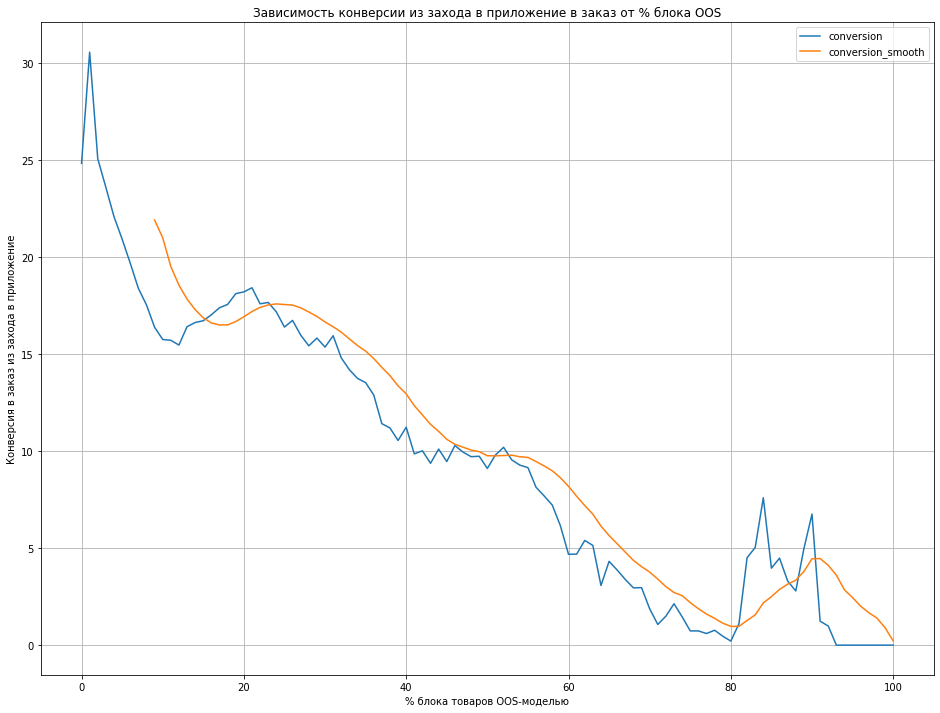

In [9]:
ax = df_stats_final.plot(x = "block_percent",y = ["conversion", "conversion_smooth"], figsize=(16,12),title="Зависимость конверсии из захода в приложение в заказ от % блока OOS")
ax.set_xlabel("% блока товаров OOS-моделью")
ax.set_ylabel("Конверсия в заказ из захода в приложение")
plt.grid(True)
plt.show()

## Какой коэф зависимости?

In [10]:
df_derivative = df_stats.groupby(by=df_stats['block_percent'].round()).conversion.mean().to_frame()
df_derivative = df_derivative.reset_index()

In [11]:
x = df_derivative['block_percent'].values
y = df_derivative['conversion'].values
d = 1

weights = np.polyfit(x,y,d)
print(weights)

y_head = x*weights[0] + weights[1]

[-0.23417558 21.34562547]


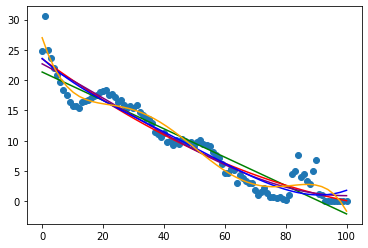

In [12]:
model1 = np.poly1d (np.polyfit (x , y , 1))
model2 = np.poly1d (np.polyfit (x , y , 2))
model3 = np.poly1d (np.polyfit (x , y , 3))
model4 = np.poly1d (np.polyfit (x , y , 4))
model5 = np.poly1d (np.polyfit (x , y , 5))

#create scatterplot
polyline = np.linspace (0,100)
plt.scatter (x , y)

#add fitted polynomial lines to scatterplot 
plt.plot (polyline, model1(polyline), color='green')
plt.plot (polyline, model2(polyline), color='red')
plt.plot (polyline, model3(polyline), color='purple')
plt.plot (polyline, model4(polyline), color='blue')
plt.plot (polyline, model5(polyline), color='orange')
plt.show()

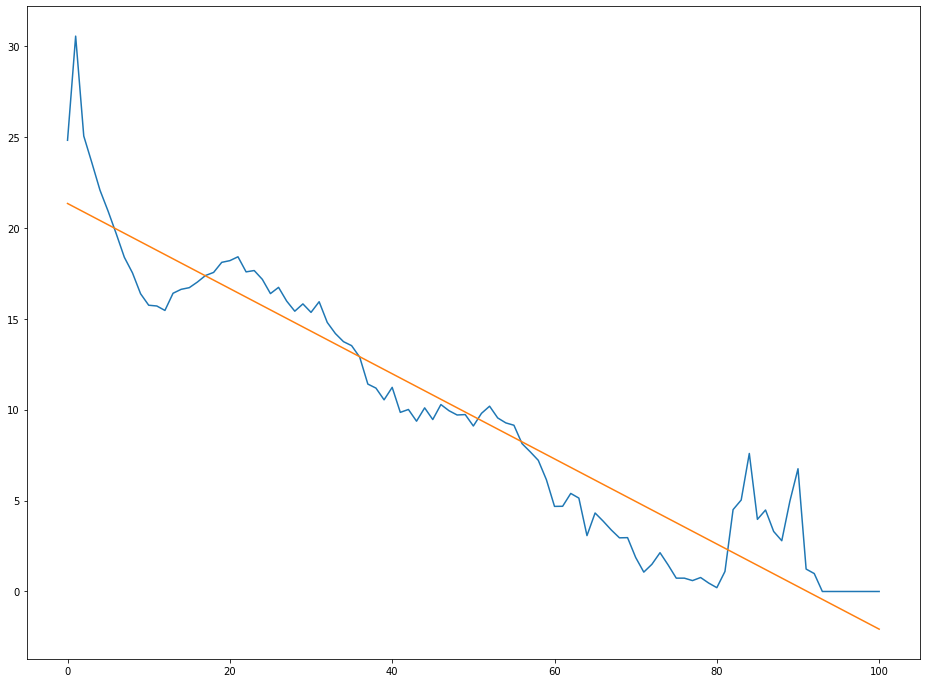

In [13]:
plt.figure(figsize=(16,12))
plt.plot(x,y)
plt.plot(x,y_head)

In [14]:
import statsmodels.api as sm
X = df_stats_final['block_percent']  # Features (independent variable)
y = df_stats_final['conversion']  

In [15]:
X = sm.add_constant(X)

In [16]:
model = sm.OLS(y, X).fit()

In [17]:
# Step 3: Display the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             conversion   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     886.9
Date:                Tue, 17 Sep 2024   Prob (F-statistic):           3.28e-51
Time:                        13:36:26   Log-Likelihood:                -226.60
No. Observations:                 101   AIC:                             457.2
Df Residuals:                      99   BIC:                             462.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            21.3456      0.455     46.900